In [ ]:
include("../src/GaussianEP.jl")

Main.GaussianEP

In [ ]:
N = 5
M = 3
w = randn(N,M)
y = zeros(N+M,)
H = [GaussianEP.TermRBM(w,y,1.0)]
μv = 3.0
βv = 5.0
μh = 5.0
βh = 4.0
P0 = [[GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N]; [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M]]

8-element Array{Main.GaussianEP.GaussianPrior{Float64},1}:
 Main.GaussianEP.GaussianPrior{Float64}(3.0, 5.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(3.0, 5.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(3.0, 5.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(3.0, 5.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(3.0, 5.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(5.0, 4.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(5.0, 4.0, 0.0)
 Main.GaussianEP.GaussianPrior{Float64}(5.0, 4.0, 0.0)

In [ ]:
out = GaussianEP.expectation_propagation(H, P0)

[-0.4095173218748933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, 1.0, 1.0, 1.0, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, 1.0, 1.0, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, -0.7360235770597817, 1.0, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, -0.7360235770597817, -0.6051469127321613, 1.0, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, -0.7360235770597817, -0.6051469127321613, -0.3974195281147479, 1.0]

[-0.4095173218748933, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, -0.7360235770597817, -0.6051469127321613, -0.3974195281147479, -0.3806348318213064]

[-0.41348342844744895, -1.1411376986000583, -0.8107764458082519, -0.4176872885526915, -0

Main.GaussianEP.EPOut{Float64}([5.032508178472669, 3.244047974579922, 7.430577356614415, 10.709944453210893, 7.2169439143752525, 7.476430302142779, 15.148996798221264, -2.9930655727437085], [0.3628470941598503, 0.23369657629148027, 0.248731776668006, 0.3509320752068296, 0.27186733817186376, 0.3736474231504452, 0.46835022119026065, 0.493096146467976], [0.5037833018038826, 1.551496908950801, -15.183524835544254, -7.216442651630646, -8.735355786493276, -0.007039853814095775, -6.620089898349453, 13.220066102319588], [-0.4456291910295685, -1.3870642184533581, -1.020819652698222, -0.4650198769558163, -0.7565810703096291, -0.755469490649672, -0.536237401818523, -0.5070999207847722], :converged, Main.GaussianEP.EPState{Float64}([0.0 0.0 … -0.5710604975468832 2.4870519884456894; 0.0 0.0 … -0.6007908003282233 0.3105334802813014; … ; -0.5710604975468832 -0.6007908003282233 … 0.0 0.0; 2.4870519884456894 0.3105334802813014 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.36284723804464125 0

In [ ]:
out.va

8-element Array{Float64,1}:
 0.3628470941598503
 0.23369657629148027
 0.248731776668006
 0.3509320752068296
 0.27186733817186376
 0.3736474231504452
 0.46835022119026065
 0.493096146467976

true


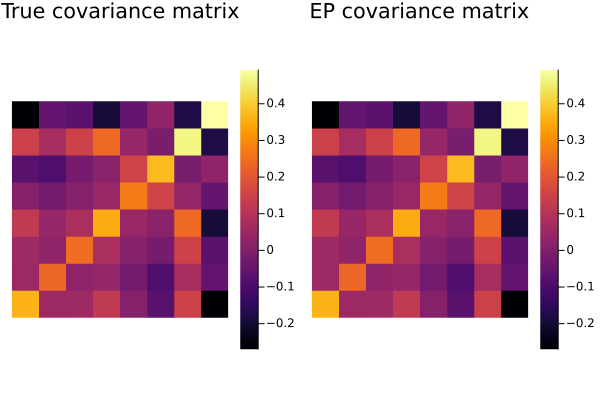

In [ ]:
using LinearAlgebra, Plots
W = zeros(N+M, N+M)
W[1:N,N+1:N+M] .= w
W[N+1:N+M,1:N] .= w'
W[1:N, 1:N] .= βv .* I(N)
W[N+1:N+M,N+1:N+M] .= βh .* I(M)

W1 = inv(W)
println(isposdef(W))
p1 = heatmap(W1, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
plot(p1,p2)

In [ ]:
diag(W1)

8-element Array{Float64,1}:
 0.3628470744916673
 0.23369657070381858
 0.24873176639848096
 0.3509320516072699
 0.27186733615325875
 0.37364738198951947
 0.46835010388009723
 0.49309601332350256

In [ ]:
eigen(W)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
8-element Array{Float64,1}:
 2.4375822655392394
 3.344739920842117
 3.6202954565382033
 5.0
 5.0000000000000036
 6.3797045434617985
 6.655260079157887
 7.5624177344607615
vectors:
8×8 Array{Float64,2}:
  0.113942    0.584757    0.0309998  …  -0.0309998  -0.584757    0.113942
  0.153305   -0.189502    0.54928       -0.54928     0.189502    0.153305
  0.310769    0.276988    0.0846033     -0.0846033  -0.276988    0.310769
  0.605273   -0.206415   -0.203764       0.203764    0.206415    0.605273
 -0.0241244  -0.0530872  -0.385556       0.385556    0.0530872  -0.0241244
 -0.153816   -0.0416376  -0.688917   …  -0.688917   -0.0416376   0.153816
  0.252663    0.653424   -0.0959052     -0.0959052   0.653424   -0.252663
  0.642263   -0.267026   -0.127261      -0.127261   -0.267026   -0.642263